<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/3_ML_Ngrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
# Imports
import re
import os
from collections import Counter
import pandas as pd
from math import log
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score, recall_score, confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# Clasificadores

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

%matplotlib inline

In [167]:
def custom_cm(cf_matrix):
  # Ref: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## N-Grams

En este experimento utilizaremos extraeremos características basadas en N-gramas. 

En concreto, obtendremos los 3-gramas, 4-gramas, 5-gramas y 6-gramas del TLD de los dominios benignos del *dataset* y una vez obtenidos, calcularemos cuantos x-grams están presentes en todas las muestras (tanto benignas como malignas), generando nuevas características: `3gram`,`4gram`,`5gram` y `6gram`


Para la obtención de n-grams utilizamos la clase `CountVectorizer` de la librería `sklearn`, proporcionándole los parámetros `analyzer='char'` (de lo contrario asumiría que se quiere realizar la división a nivel de palabra) y  `ngram_range=(x, x)`, donde `x` es el número de elementos del n-gramas. 

Otras posibilidades de análisis basado en n-gramas habrían sido:

- Utilizar "*masked n-grams*", como el propuesto en el artículo ["Detection of algorithmically generated malicious domain names using masked N-grams"](https://zaguan.unizar.es/record/87544/files/texto_completo.pdf). En este caso, los dominios son previamente tratados, mapeandose todas las vocales al carácter "v", las consonantes al caracter "c", los dígitos al caracter "n" y el resto de símbolos al caracter "s". Por ejemplo el dominio "google" se convertiría en a "cvvccv".

- Realizar la extracción de n-grams a partir de un diccionario de las palabras más comunes en inglés, como lo propuesto en el proyecto europeo [SOCCRATES](https://www.soccrates.eu/wp-content/uploads/2022/05/SOCCRATES_D4.3-Threat-Identification-and-Threat-Trend-prediction-%E2%80%93-Final-Prototype-Final.pdf), en la que combinan el núero de n-gramas con otras características como la longitud del dominio, ...


In [168]:
DATASET_PATH='/content/drive/MyDrive/TFM/data_processed/dga.csv'
df = pd.read_csv(DATASET_PATH,index_col=0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [169]:
df.shape

(1142536, 11)

In [187]:
df.head(4)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
0,47faeb4f1b75a48499ba14e9b1cd895a.org,bamital,malign,org,47faeb4f1b75a48499ba14e9b1cd895a,3,18,32,0,3.426109,0.230769,25,4,0,0
1,47faeb4f1b75a48499ba14e9b1cd895a.info,bamital,malign,info,47faeb4f1b75a48499ba14e9b1cd895a,3,18,32,0,3.426109,0.230769,25,4,0,0
2,47faeb4f1b75a48499ba14e9b1cd895a.co.cc,bamital,malign,cc,co,3,0,2,0,1.000000,1.000000,0,0,0,0
3,47faeb4f1b75a48499ba14e9b1cd895a.cz.cc,bamital,malign,cc,cz,3,0,2,0,1.000000,0.000000,0,0,0,0


In [170]:

benign_cv_3gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3, 3))#,max_features=500)
benign_cv_4gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(4, 4))#,max_features=500)
benign_cv_5gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(5, 5))#,max_features=500)
benign_cv_6gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(6, 6))#,max_features=500)

benign_cv_3gram.fit(df[df.category=='benign'].sld.values.astype('U'))
benign_cv_4gram.fit(df[df.category=='benign'].sld.values.astype('U'))
benign_cv_5gram.fit(df[df.category=='benign'].sld.values.astype('U'))
benign_cv_6gram.fit(df[df.category=='benign'].sld.values.astype('U'))

CountVectorizer(analyzer='char', ngram_range=(6, 6))

In [171]:
sum_3gram=benign_cv_3gram.transform(df.sld.values.astype('U')).sum(axis=1)
sum_4gram=benign_cv_4gram.transform(df.sld.values.astype('U')).sum(axis=1)
sum_5gram=benign_cv_5gram.transform(df.sld.values.astype('U')).sum(axis=1)
sum_6gram=benign_cv_6gram.transform(df.sld.values.astype('U')).sum(axis=1)

# Nuevas features: 3gram, 4gram, 5gram y 6gram
df['3gram']=np.squeeze(np.asarray(sum_3gram))
df['4gram']=np.squeeze(np.asarray(sum_4gram))
df['5gram']=np.squeeze(np.asarray(sum_5gram))
df['6gram']=np.squeeze(np.asarray(sum_6gram))


Ejemplo de muestras con más de dos 3-grams:

In [172]:
df[df['3gram']>1].sample(5)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
789063,scptp1.com,NaN,benign,com,scptp1,3,1,6,0,2.251629,0.000000,4,3,2,1
878099,enschederamp.nl,NaN,benign,nl,enschederamp,3,0,12,0,3.188722,0.500000,10,9,8,7
1033248,szuvj.com,NaN,benign,com,szuvj,3,0,5,0,2.321928,0.250000,3,2,1,0
697902,devo.com,NaN,benign,com,devo,3,0,4,0,2.000000,1.000000,2,1,0,0
357757,cxczwhgdop.net,pushdotid,malign,net,cxczwhgdop,3,0,10,0,3.121928,0.111111,8,2,0,0


Para el entrenamiento de los clasificadores únicamente tenemos en cuenta los n-grams

In [173]:
X = df[['3gram','4gram','5gram','6gram']]
y = df['category']

In [174]:
benign_cv_3gram.get_feature_names()[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['---', '--1', '--7', '--a', '--b', '--c', '--g', '--h', '--k', '--l']

In [175]:
# 3-Grams más comunes
import operator
ngrams=benign_cv_3gram.vocabulary_
sorted_d = dict( sorted(ngrams.items(), key=operator.itemgetter(1),reverse=False))
# 10 ngrams mas comunes
#sorted_d
list(sorted_d.items())[:10]
#{k: sorted_d[k] for k in list(sorted_d)[:10]}

[('---', 0),
 ('--1', 1),
 ('--7', 2),
 ('--a', 3),
 ('--b', 4),
 ('--c', 5),
 ('--g', 6),
 ('--h', 7),
 ('--k', 8),
 ('--l', 9)]

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regresión logística

In [177]:
# Model Building using logistic Regression
logit = LogisticRegression()
logit.fit(X_train, y_train)

LogisticRegression()

In [178]:
y_pred_logit = logit.predict(X_test)

In [179]:
print("Accuracy del clasificación basado en regresión logística: ",logit.score(X_test, y_test))

Accuracy of Logistic Regression Model is  0.9667757802790274


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


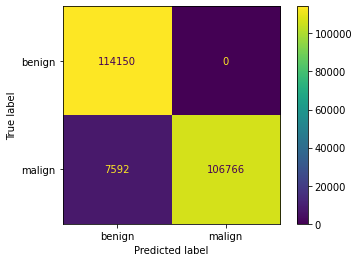

In [180]:
plot_confusion_matrix(logit, X_test, y_test)

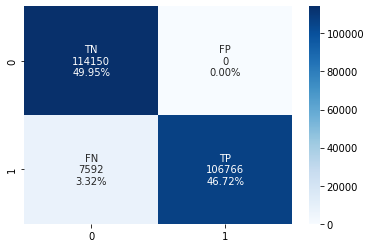

In [181]:
cf_matrix = confusion_matrix(y_test, y_pred_logit)
custom_cm(cf_matrix)

# Random Forest

In [182]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [183]:
print("Accuracy del clasificador Random Forest:",rf.score(X_test, y_test))

Accuracy of Random Forest Model is  0.9784121343672869


In [184]:
y_test

821717    benign
68975     malign
911244    benign
20818     malign
457795    malign
           ...  
304829    malign
671472    benign
938678    benign
316124    malign
809901    benign
Name: category, Length: 228508, dtype: object

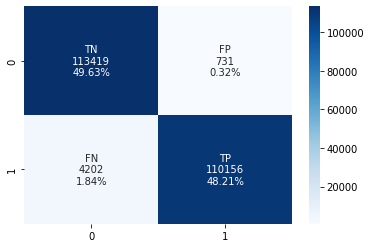

In [185]:
cf_matrix = confusion_matrix(y_test, y_pred_rf)
#print(cf_matrix)
custom_cm(cf_matrix)

In [186]:
# Cross-validation
rf_cv = cross_val_score(RandomForestClassifier(), X, y, cv=10)
mean_rf_cv = np.mean(rf_cv)

print("Accuracy medio del modelo Random Forest es ", mean_rf_cv)

Average accuracy of Random Forest Model is  0.9750047908694566
